# General

This notebook contains the experiments regarding the trigonometric functions.

It can be used in order to re-generate the plots in the report.

In [25]:
import numpy as np
import scipy as sp
from scipy import sparse as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm.notebook import tqdm_notebook as tqdm
from baryrat import aaa

%matplotlib inline

from src.helpers import plot_eigenvalues
from src.experiments import get_convergence_trig
from src.solvers import Cosine, Sinc, Sinc2

In [26]:
# Set the desired theme
sns.set_theme(font_scale=1.2)

# Reading the test matrices

In [27]:
A_LE = {}
for h in [0.1, 0.07, 0.04]:
    # Read the matrix and its vectors
    A_LE[h] = sp.io.loadmat(f'data/linearelasticitymatrices/h{h:.0e}.mat', appendmat=False)
    A = A_LE[h]['A'].toarray()

    # Reshape the vectors
    A_LE[h]['u0'] = A_LE[h]['u0'].reshape(-1)
    A_LE[h]['v0'] = A_LE[h]['v0'].reshape(-1)
    A_LE[h]['b'] = A_LE[h]['b'].reshape(-1)

    # Rectify the matrix
    tol = 1e-02
    assert sp.linalg.issymmetric(A, atol=tol, rtol=0)
    A[np.abs(A) < tol] = 0
    A = (sps.tril(A) + sps.tril(A).T).toarray()

    # Get the square root of the matrix and make it symmetric
    H = sp.linalg.sqrtm(A)
    # NOTE: No need because they will automatically be symmetric
    # tol = 1e-08
    # assert sp.linalg.issymmetric(H, atol=tol, rtol=0)
    # H = sps.tril(H) + sps.tril(H).T

    # Compute its eigenvalues and eigenvectors
    dA, SA = sp.linalg.eigh(A)
    dH, SH = sp.linalg.eigh(H)

    # Store the rectified matrix and its square root
    A_LE[h]['A'] = sps.csc_matrix(A)
    A_LE[h]['H'] = sps.csc_matrix(H)

    # Store the eigenvalues and eigenvectors
    A_LE[h]['dA'] = dA
    A_LE[h]['SA'] = SA
    A_LE[h]['dH'] = dH
    A_LE[h]['SH'] = SH

# Properties of the test matrices

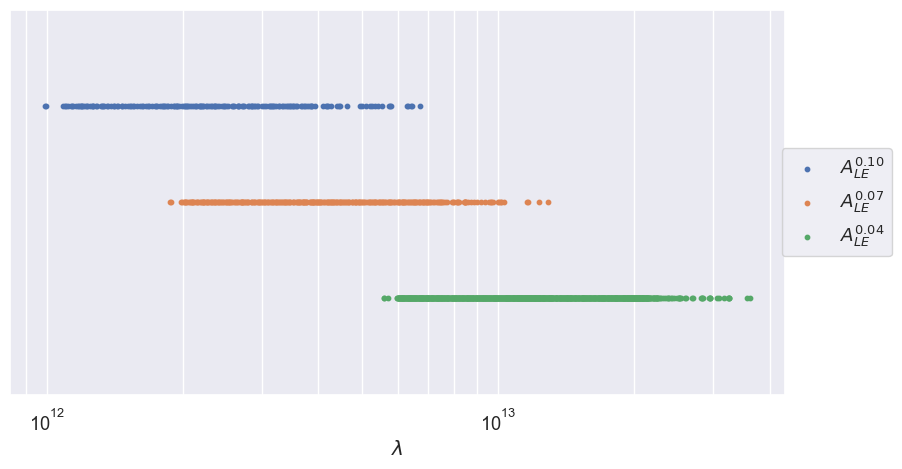

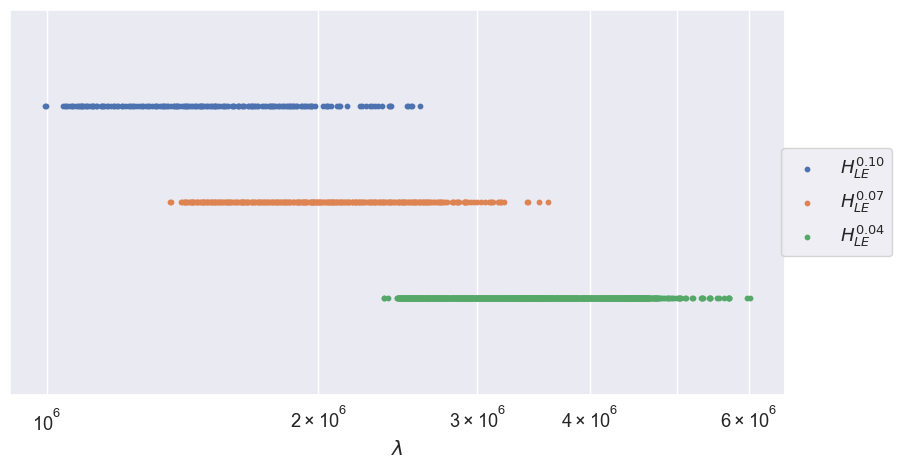

In [28]:
plot_eigenvalues(
    As=[A_LE[h]['A'] for h in [0.1, 0.07, 0.04]],
    legends=['$A_{LE}^{0.10}$', '$A_{LE}^{0.07}$', '$A_{LE}^{0.04}$'],
)
ax = plt.gca()
ax.set(xscale='log')
ax.grid(which='minor')

plot_eigenvalues(
    As=[A_LE[h]['H'] for h in [0.1, 0.07, 0.04]],
    legends=['$H_{LE}^{0.10}$', '$H_{LE}^{0.07}$', '$H_{LE}^{0.04}$'],
)
ax = plt.gca()
ax.set(xscale='log')
ax.grid(which='minor')

# The AAA algorithm

## What happens to `m` poles when the spectrum becomes wider?

Nothing can be concluded. The poles are completely different.

In [40]:
# Set the parameters
m = 20
intervals = [(1e+06, 6e+06), (1e+06, 1e+07)]

# Instantiate the lists
ns = []
ts = []
ids = []
nodes = []
poles_real = []
poles_imag = []

# Get the poles
for n in [2e03]:
    for t in [1e-05]:
        for id in range(len(intervals)):
            f = Sinc2(t=t)
            Z = np.linspace(intervals[id][0], intervals[id][1], int(n))
            r = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1)
            assert len(r.poles()) == m
            ns.append(n)
            ts.append(t)
            ids.append(id)
            nodes.append(r.nodes)
            poles_real.append(r.poles().real)
            poles_imag.append(r.poles().imag)

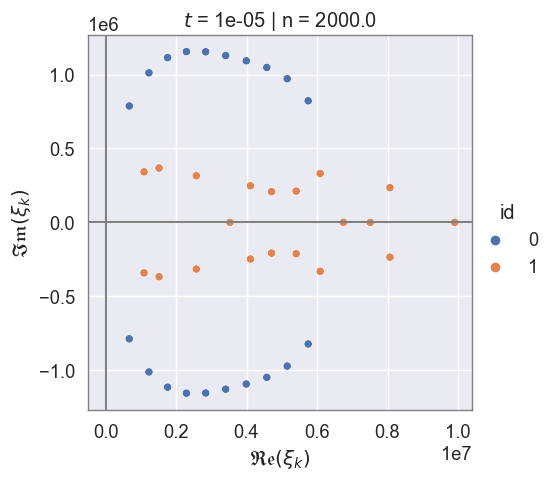

In [41]:
# Set up the results
data = pd.DataFrame({'t': ts, 'n': ns, 'id': ids})
df_real = pd.DataFrame({f'${m+1}$': [p[m] for p in poles_real] for m in range(m)})
df_real = pd.concat([data, df_real], axis=1)
df_real = df_real.melt(('t', 'n', 'id'), var_name='k', value_name='$\\mathfrak{Re}(\\xi_k)$')
df_imag = pd.DataFrame({f'${m+1}$': [p[m] for p in poles_imag] for m in range(m)})
df_imag = pd.concat([data, df_imag], axis=1)
df_imag = df_imag.melt(('t', 'n', 'id'), var_name='k', value_name='$\\mathfrak{Im}(\\xi_k)$')
df = df_real.merge(df_imag)

# Plot
fg = sns.relplot(
    data=df.rename(columns={'t': '$t$'}),
    x='$\\mathfrak{Re}(\\xi_k)$',
    y='$\\mathfrak{Im}(\\xi_k)$',
    row='$t$',
    col='n',
    hue='id',
    kind='scatter',
    palette='deep',
    facet_kws={'sharex': True, 'sharey': True, 'despine': False},
)

# Plot settings
for ax in fg.axes.flatten():
    ax.axhline(y=0, color='gray', linestyle='-')
    ax.axvline(x=0, color='gray', linestyle='-')
    for spine in ax.spines.values():
        spine.set_color('gray')
        spine.set_linewidth(1)

## What happens to the maximum error when m is increased?

In [ ]:
# Set the interval
interval = [1e+06, 6e+06]

# Instantiate the lists
ns = []
ms = []
ts = []
names = []
errors = []
poles_real = []
poles_imag = []

# Get the errors
Z_err = np.linspace(interval[0], interval[1], int(10e03))
for n in [2e03]:
    Z = np.linspace(interval[0], interval[1], int(n))
    for m in tqdm([int(m) for m in np.linspace(1, 80, 50)]):
        for t in [5e-06]:
            for f in [Cosine(t=t), Sinc(t=t), Sinc2(t=t)]:
                r = aaa(Z=Z, F=f.scalar, mmax=(m+1), tol=-1)
                ns.append(n)
                ms.append(m)
                ts.append(t)
                names.append(str(f))
                errors.append(np.abs(f.scalar(Z_err) - r(Z_err)).max())
                poles_real.append(r.poles().real)
                poles_imag.append(r.poles().imag)

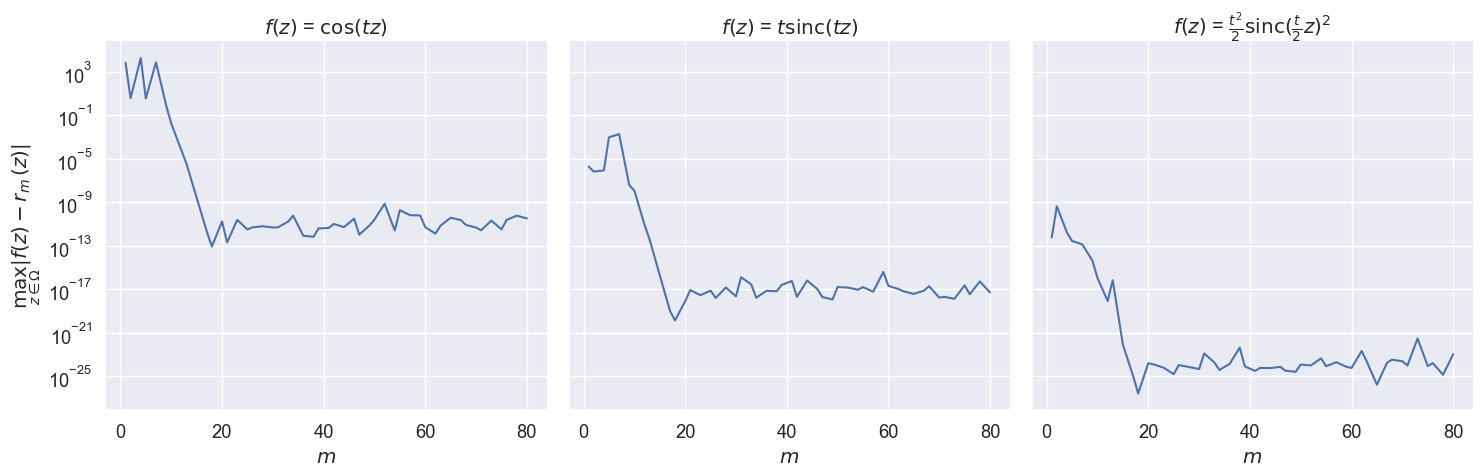

In [32]:
# Refine the results
data = pd.DataFrame({'$f(z)$': names, 't': ts, 'e': errors, 'm': ms, 'n': ns})
data.loc[data['$f(z)$'] == '$\\cos(tA)$', '$f(z)$'] = '$\\cos(t z)$'
data.loc[data['$f(z)$'] == '$t \\mathrm{sinc}(tA)$', '$f(z)$'] = '$t \\mathrm{sinc}(t z)$'
data.loc[data['$f(z)$'] == '$\\frac{t^2}{2} \\mathrm{sinc}(\\frac{t}{2} A)^2$', '$f(z)$'] = '$\\frac{t^2}{2} \\mathrm{sinc}(\\frac{t}{2} z)^2$'

# Plot
fg = sns.relplot(
    data=data.rename(columns={'t': '$t$', 'm': '$m$'}),
    x='$m$',
    y='e',
    col='$f(z)$',
    kind='line',
    facet_kws={'sharex': True, 'sharey': True},
)
fg.set(yscale='log', ylabel=f'$\\max_{{z \\in \\Omega}} |f(z) - r_m(z)|$')

# Experiments

The following codes can be used to regenerate the results in `results/trigfuncs_mm.csv` and `results/trigfuncs_mk.csv`.

Alternatively, they can be loaded to regenerate the plots.

## Load the results

In [38]:
df = pd.read_csv('results/trigfuncs_mm.csv')
# df = pd.read_csv('results/trigfuncs_mk.csv')

## Regenerate the results

In [ ]:
# Turn off the warnings
import warnings
warnings.filterwarnings('ignore')

# Set the parameters
mmax_PA = 120
mmax_RA = 120
ts = [5e-06, 2e-05]
nms = 60

# Set the test matrices
hs = [0.04]
names = [f'$H_{{LE}}^{{h={h:.2f}}}$' for h in hs]
matrices = [A_LE[h]['H'].toarray() for h in hs]
vectors = [(A_LE[h]['u0'], A_LE[h]['v0'], A_LE[h]['b']) for h in hs]
intervals = [(A_LE[h]['dH'].min(), A_LE[h]['dH'].max()) for h in hs]

# Get the covnergence results
dfs_ = []
pbar_A = tqdm(total=len(matrices), desc='Matrices (A)', leave=True)
for name, A, vectors, interval in zip(names, matrices, vectors, intervals):
    pbar_A.desc = f'Matrices (A={name})'
    pbar_A.refresh()

    # Get random vector v and normalize it
    n = A.shape[0]
    v = np.random.random_sample(size=(n,))
    v = v / np.linalg.norm(v)
    u0, v0, b0 = vectors

    pbar_p = tqdm(total=len(ts), desc='Time steps (t)', leave=False)
    for t in ts:
        pbar_p.desc = f'Time steps (t={t:.0e})'
        pbar_p.refresh()
        d = get_convergence_trig(
            funcs=[
                Cosine(t=t),
                # Sine(t=t),
                Sinc(t=t),
                Sinc2(t=t)
            ],
            A=A,
            v=v,
            ks=[10, 20, 30, 50, 80,],
            # Change to 'last' for getting the results for rational functions of type (m, k)
            repeat='all',
            interval=interval,
            mmax_PA=min(n-20, mmax_PA),
            mmax_RA=min(n-20, mmax_RA),
            nms=nms,
        )
        d['name'] = name
        d['n'] = n
        d['t'] = f'{t:.0e}'
        dfs_.append(pd.DataFrame(d))

        pbar_p.update()

    pbar_p.close()
    pbar_A.update()

    pd.concat(dfs_).to_csv('tmp.csv', index=False)

pbar_A.close()

# Build the dataframe and save it in a temporary file
# (useful in the case that the notebook crashes)
df = pd.concat(dfs_)
df.to_csv('results/tmp.csv', index=False)

# Finish the process
warnings.filterwarnings('default')
print('Done!')

In [15]:
# Store the results
df.to_csv('results/trigfuncs_new.csv', index=False)

## Convergence plots

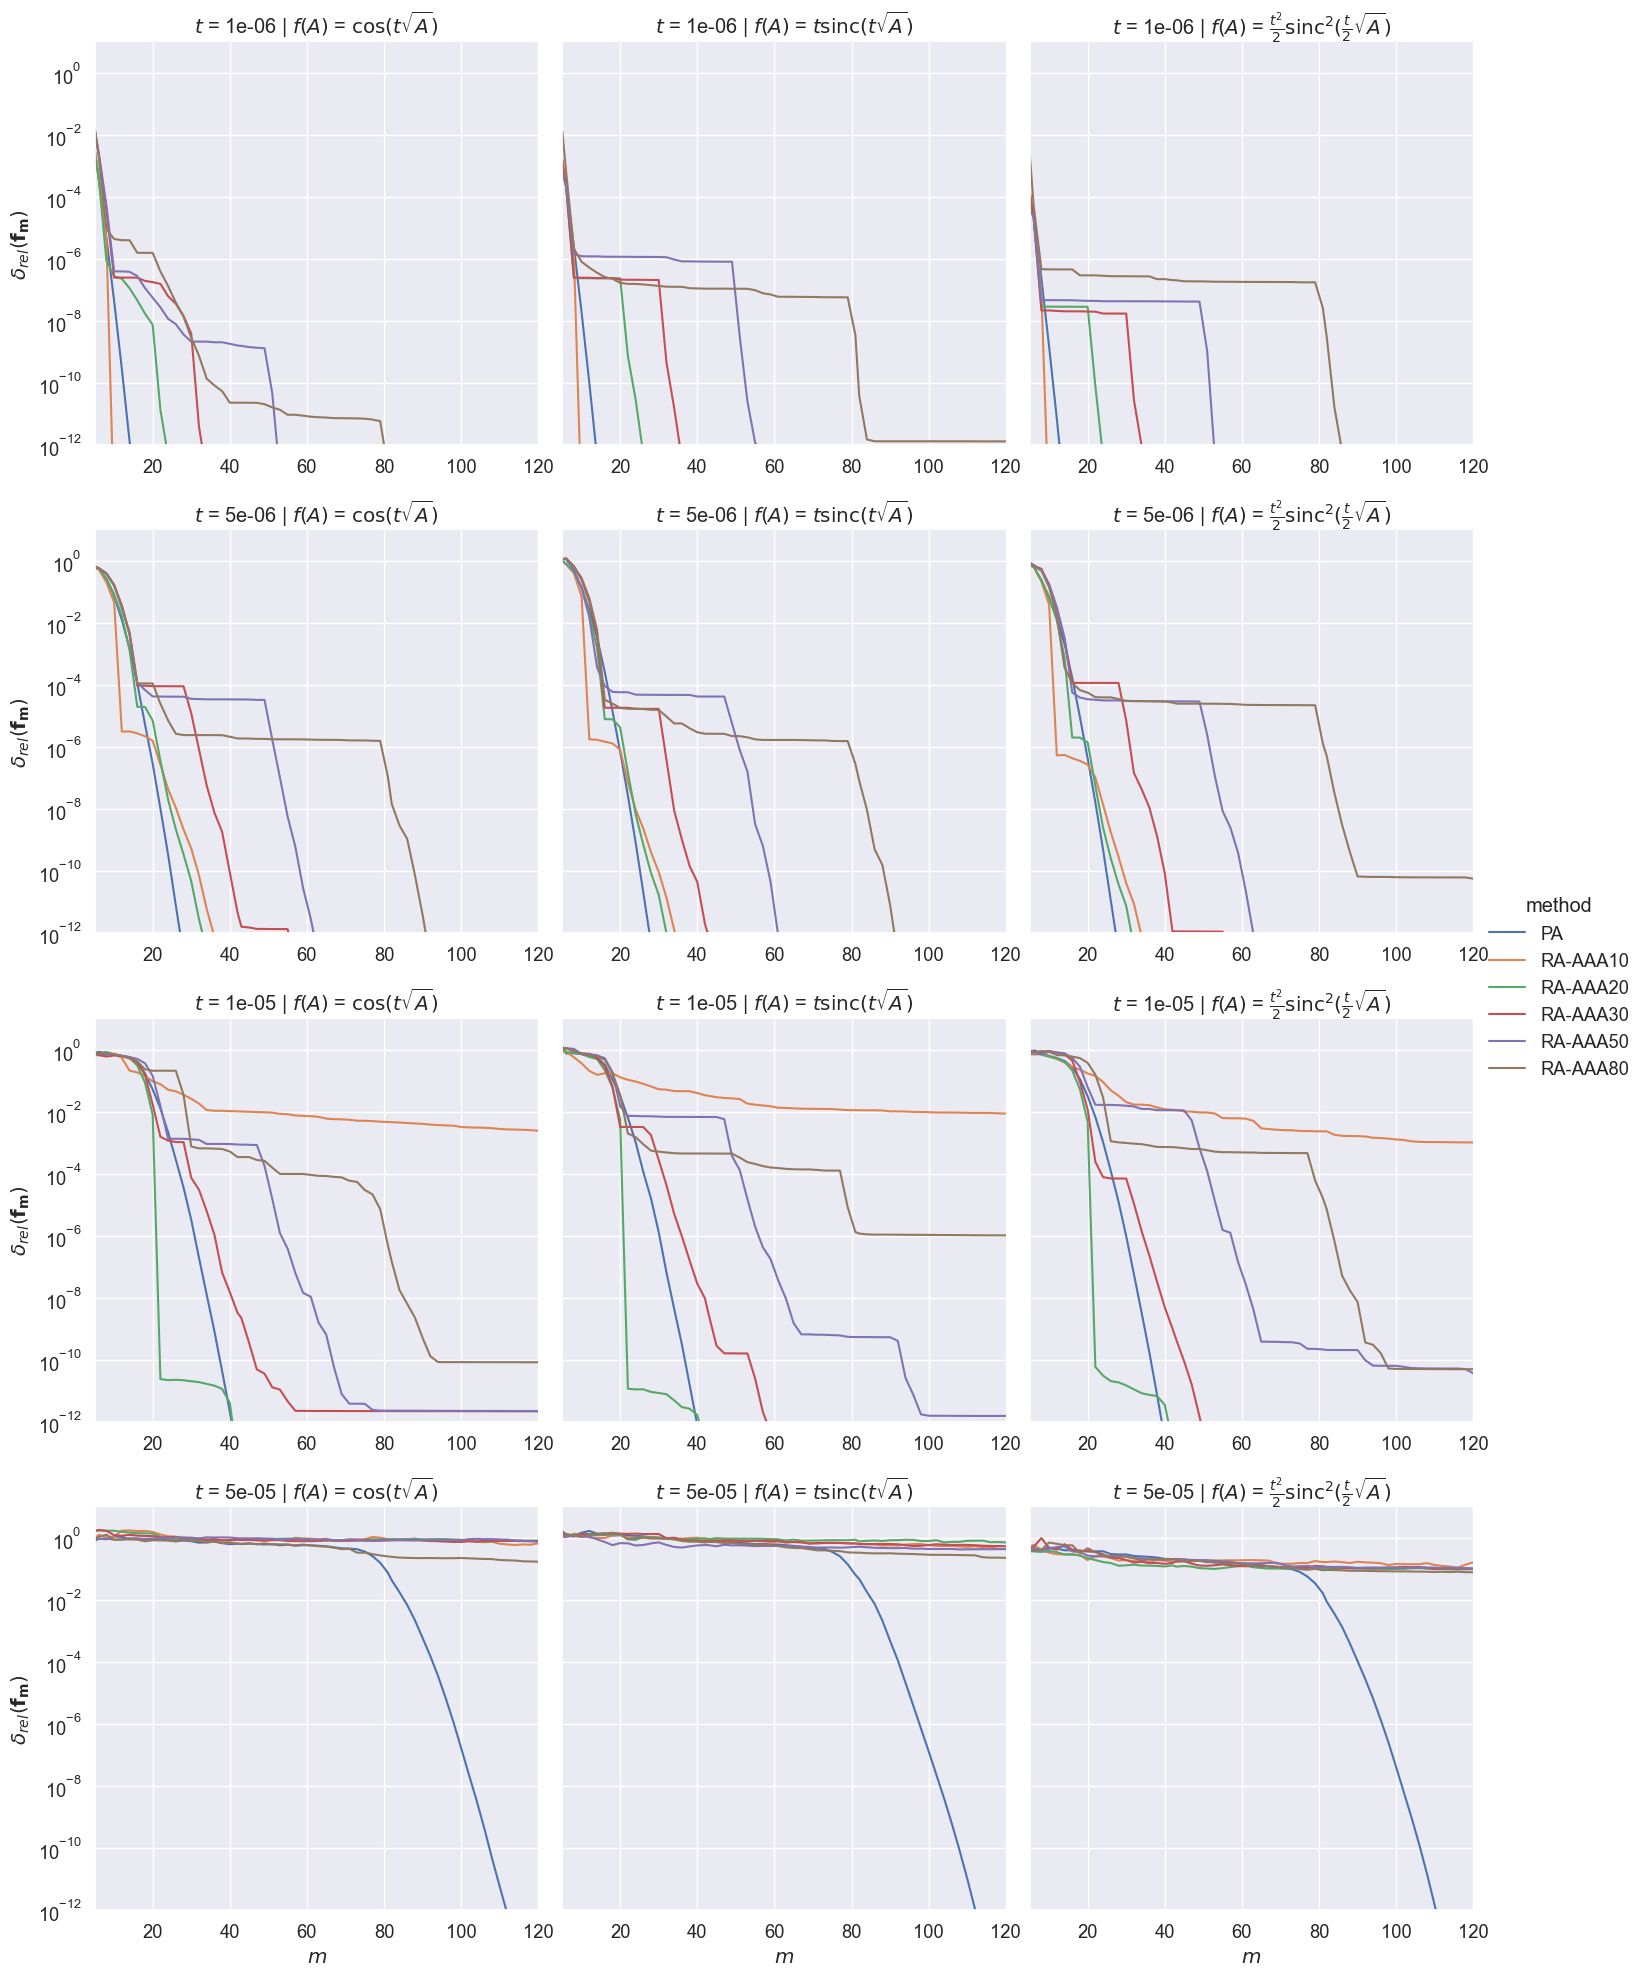

In [39]:
# Filter the results
data = df[
    # Method
    ((df['method'] != 'EX'))
]

# Change the name of the functions for plotting
data.loc[data['f'] == '$\\cos(tA)$', 'f'] = '$\\cos(t\\sqrt{A})$'
data.loc[data['f'] == '$t \\mathrm{sinc}(tA)$', 'f'] = '$t \\mathrm{sinc}(t\\sqrt{A})$'
data.loc[data['f'] == '$\\frac{t^2}{2} \\mathrm{sinc}(\\frac{t}{2} A)^2$', 'f'] = '$\\frac{t^2}{2} \\mathrm{sinc}^2(\\frac{t}{2} \\sqrt{A})$'

# Plot
fg = sns.relplot(
    data=data.rename(columns={'name': '$A$', 'm': '$m$', 'f': '$f(A)$', 't': '$t$'}),
    x='$m$',
    y='err',
    kind='line',
    row='$t$',
    col='$f(A)$',
    hue='method',
    palette='deep',
    facet_kws={'sharex': False},
)

# Plot settings
fg.set(
    yscale='log',
    xlim=[5, 120],
    ylim=[1e-12, 1e+01],
    ylabel='$\\delta_{rel}(\\mathbf{f_m})$',
)